In [1]:
import os
from os.path import join
import mlflow

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytorch_lightning as pl

from src.dyslexia_dataloader import DyslexiaDataModule
from src.dyslexia_training_module import DyslexiaTrainingModule

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [2]:
DATA_PATH = join("..", "data")
IMAGES_DIR_NAME = "dyslexia_images_big"

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Utility Functions

In [4]:
def show_loss_graph(experiment_id, run_id, save_path: str = join("..", "logging", "plots")):
    metrics_path = join("mlruns", str(experiment_id), run_id, "metrics")
    
    fig, ax = plt.subplots(figsize=(10, 6))
    stages = ("train", "val")
    losses = ("loss",)
    for stage in stages:
        for loss in losses:
            name = f'{stage}_{loss}_epoch'
            path = join(metrics_path, name)
            values = pd.read_csv(path, delimiter=' ').to_numpy()
            
            ax.plot(values[:, 2].flatten(), values[:, 1].flatten(), label=name)
        
    ax.legend()
    ax.set(title="Model performance", xlabel="Epoch", ylabel="Loss")
    
    if not os.path.exists(save_path):
        os.mkdir(save_path)  
    fig.savefig(os.path.join(save_path, f"training_plot_{experiment_id}_{run_id}"))

In [5]:
def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    return inp

### MLFLOW Setup

In [6]:
run = None

EXPERIMENT_NAME = "dyslexia_resnet"
RUN_ID = None
MLFLOW_LOGGING_PATH = join("..", "logging", "mlruns")

if mlflow.get_experiment_by_name(EXPERIMENT_NAME) is None:
    EXPERIMENT_ID = mlflow.create_experiment(EXPERIMENT_NAME, artifact_location=MLFLOW_LOGGING_PATH)
else:
    EXPERIMENT_ID = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

### Hyperparameters

In [7]:
BATCH_SIZE  = 64
MAX_EPOCHS  = 30
NUM_CLASSES = 2
PATIENCE    = 10

WIDTH  = 224
HEIGHT = 224

### Dataset

In [8]:
IMAGE_ID = 300

In [9]:
data_module = DyslexiaDataModule(
    batch_size=BATCH_SIZE,
    data_path=DATA_PATH,
    train_frac=0.85,
    val_frac=0.10,
    width=WIDTH,
    height=HEIGHT,
    images_dir_name=IMAGES_DIR_NAME
)

Grade: 0.0


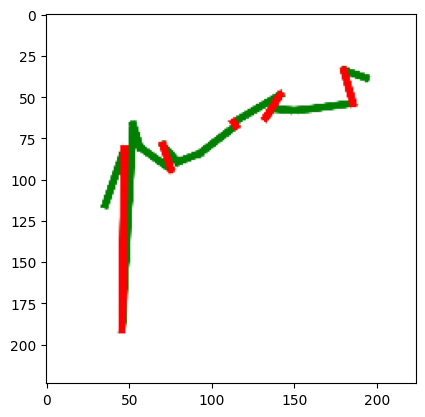

In [10]:
image, grade = data_module.ds_train[IMAGE_ID]
print(f"Grade: {grade}")
plt.imshow(reverse_transform(image));

### Callbacks

In [11]:
# Save the model periodically by monitoring a quantity.
ModelCheckpoint = ModelCheckpoint(
    dirpath=join("..", "logging", "runs", "dyslexia_classification"),
    filename="{epoch}-{train_loss:.3f}-{val_loss:.3f}",
    monitor="val_loss",
    mode="min",
    save_top_k=1,
)

# Monitor a metric and stop training when it stops improving.
EarlyStopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=PATIENCE,
    verbose=True,
)

### Training

In [12]:
torch.set_float32_matmul_precision('high')
trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    callbacks=[EarlyStopping, ModelCheckpoint],
    enable_progress_bar=False
)

model = DyslexiaTrainingModule(num_classes=NUM_CLASSES)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [13]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

mlflow.pytorch.autolog()

with mlflow.start_run(experiment_id=EXPERIMENT_ID) as run:
    trainer.fit(model, data_module)

2024/12/19 13:57:30 WARNING mlflow.utils.autologging_utils: MLflow pytorch autologging is known to be compatible with 1.9.0 <= torch <= 2.5.1, but the installed version is 2.5.1+cu124. If you encounter errors during autologging, try upgrading / downgrading torch to a compatible version, or try upgrading MLflow.
/home/vagiz/Desktop/desktop_vagiz/HSE/Programming/sna-project/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/vagiz/Desktop/desktop_vagiz/HSE/Programming/sna-project/logging/runs/dyslexia_classification exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Stage: TrainerFn.FITTING
Train: 6563 images
Validation: 772 images
Test: 386 images




  | Name  | Type           | Params | Mode 
-------------------------------------------------
0 | model | DyslexiaResNet | 11.2 M | train
-------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode
Metric val_loss improved. New best score: 0.605
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.605. Signaling Trainer to stop.
2024/12/19 14:00:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [14]:
RUN_ID = run.info.run_id if run is not None else RUN_ID

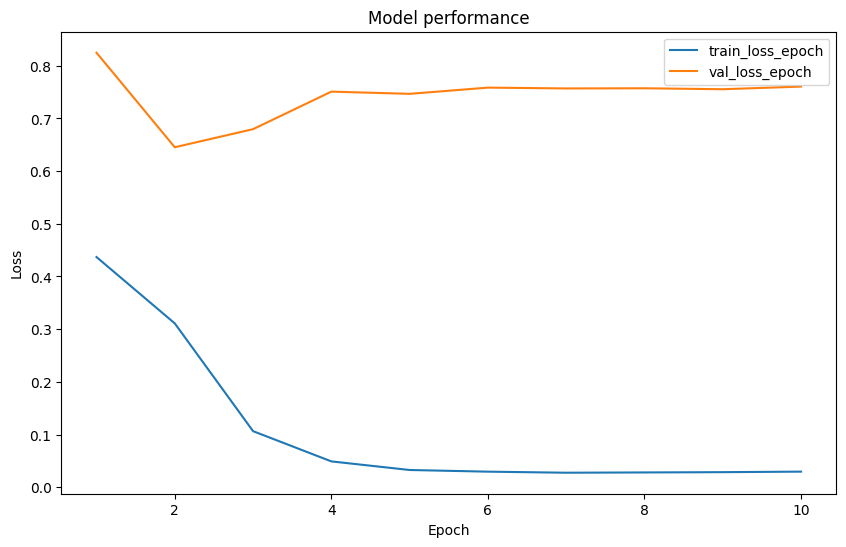

In [15]:
show_loss_graph(EXPERIMENT_ID, RUN_ID)

### Metrics

In [16]:
trainer.test(model, data_module);

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Stage: TrainerFn.TESTING
Train: 6563 images
Validation: 772 images
Test: 386 images



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric         ┃        DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1_0_epoch       │     0.8517943024635315     │
│      test_f1_1_epoch       │     0.4920022189617157     │
│    test_f1_macro_epoch     │      0.67448890209198      │
│      test_loss_epoch       │     0.6526229381561279     │
│     test_prec_0_epoch      │     0.8178228735923767     │
│     test_prec_1_epoch      │     0.5749484300613403     │
│ test_precision_macro_epoch │     0.6989763379096985     │
│    test_recall_0_epoch     │     0.8910467028617859     │
│    test_recall_1_epoch     │     0.4408102333545685     │
│  test_recall_macro_epoch   │     0.6685191988945007     │
└────────────────────────────┴────────────────────────────┘